In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

# Load data
ratings = pd.read_csv("/kaggle/input/goodbooks-10k/ratings.csv")
books = pd.read_csv("/kaggle/input/goodbooks-10k/books.csv")

# Encode user and book IDs
user_enc = LabelEncoder()
ratings['user_id'] = user_enc.fit_transform(ratings['user_id'])
book_enc = LabelEncoder()
ratings['book_id'] = book_enc.fit_transform(ratings['book_id'])

# Normalize ratings
scaler = StandardScaler()
ratings['rating'] = scaler.fit_transform(ratings[['rating']])

# Split data
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Dataset class to help with data loaders
class RatingsDataset(Dataset):
    def __init__(self, ratings):
        self.user_ids = torch.tensor(ratings['user_id'].values, dtype=torch.long)
        self.book_ids = torch.tensor(ratings['book_id'].values, dtype=torch.long)
        self.ratings = torch.tensor(ratings['rating'].values, dtype=torch.float)
    
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.user_ids[idx], self.book_ids[idx], self.ratings[idx]

train_dataset = RatingsDataset(train_data)
test_dataset = RatingsDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [3]:
import torch.nn as nn

class NCFModel(nn.Module):
    def __init__(self, num_users, num_books, embedding_size):
        super(NCFModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.book_embedding = nn.Embedding(num_books, embedding_size)
        self.fc1 = nn.Linear(embedding_size * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
        
    def forward(self, user_ids, book_ids):
        user_embeds = self.user_embedding(user_ids)
        book_embeds = self.book_embedding(book_ids)
        x = torch.cat([user_embeds, book_embeds], dim=-1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Model Parameters
num_users = ratings['user_id'].nunique()
num_books = ratings['book_id'].nunique()
embedding_size = 50

# Initialize Model
model = NCFMofdel(num_users, num_books, embedding_size).to('cuda')

Epoch 1/11, Train Loss: 0.8356, Validation Loss: 0.7525
Epoch 2/11, Train Loss: 0.7693, Validation Loss: 0.7518
Epoch 3/11, Train Loss: 0.7629, Validation Loss: 0.7569
Epoch 4/11, Train Loss: 0.7576, Validation Loss: 0.7431
Epoch 5/11, Train Loss: 0.7514, Validation Loss: 0.7394
Epoch 6/11, Train Loss: 0.7452, Validation Loss: 0.7354
Epoch 7/11, Train Loss: 0.7388, Validation Loss: 0.7314
Epoch 8/11, Train Loss: 0.7313, Validation Loss: 0.7274
Epoch 9/11, Train Loss: 0.7231, Validation Loss: 0.7193
Epoch 10/11, Train Loss: 0.7158, Validation Loss: 0.7181
Epoch 11/11, Train Loss: 0.7098, Validation Loss: 0.7129


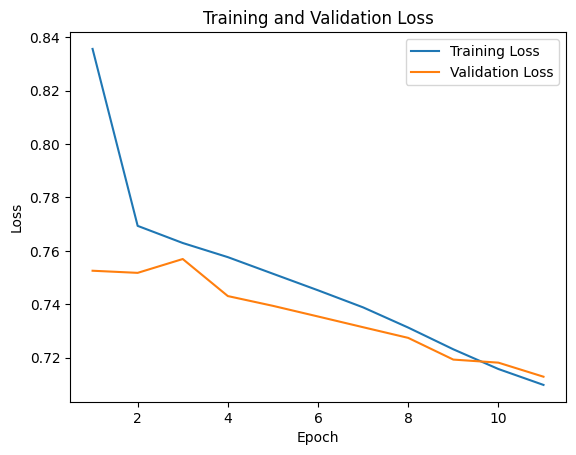

In [4]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00146)

import matplotlib.pyplot as plt

# Training Loop
num_epochs = 11
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for user_ids, book_ids, ratings in train_loader:
        user_ids = user_ids.to('cuda')
        book_ids = book_ids.to('cuda')
        ratings = ratings.to('cuda')
        
        optimizer.zero_grad()
        outputs = model(user_ids, book_ids)
        loss = criterion(outputs.squeeze(), ratings)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation Loop
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for user_ids, book_ids, ratings in test_loader:
            user_ids = user_ids.to('cuda')
            book_ids = book_ids.to('cuda')
            ratings = ratings.to('cuda')

            outputs = model(user_ids, book_ids)
            loss = criterion(outputs.squeeze(), ratings)

            val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

torch.save(model.state_dict(), 'ncf_model.pth')

In [19]:
model.load_state_dict(torch.load('ncf_model.pth'))

# Extract book embeddings
book_weights = model.book_embedding.weight.data.cpu().numpy()

# Normalize book embeddings
book_weights = book_weights / np.linalg.norm(book_weights, axis=1).reshape(-1, 1)

# Find similar books
def find_similar_books(book_id, book_weights, k=4):
    book_vec = book_weights[book_id]
    similarity = np.dot(book_weights, book_vec)
    similar_books = np.argsort(-similarity)[1:k+1]
    return similar_books

In [20]:
# Example 1
book_id = book_enc.transform([3])[0]
similar_books = find_similar_books(book_id, book_weights)

book_titles = dict(zip(book_enc.transform(books['book_id']), books['title']))
print(f"Because you read {book_titles[book_id]}")
for index, similar_book_id in enumerate(similar_books):
    print(index + 1, book_titles[similar_book_id])

Because you read Twilight (Twilight, #1)
1 New Moon (Twilight, #2)
2 Breaking Dawn (Twilight, #4)
3 Eclipse (Twilight, #3)
4 Fifty Shades Freed (Fifty Shades, #3)


In [21]:
# Example 2
book_id = book_enc.transform([5])[0]
similar_books = find_similar_books(book_id, book_weights)

book_titles = dict(zip(book_enc.transform(books['book_id']), books['title']))
print(f"Because you read {book_titles[book_id]}")
for index, similar_book_id in enumerate(similar_books):
    print(index + 1, book_titles[similar_book_id])

Because you read The Great Gatsby
1 Macbeth
2 Lord of the Flies
3 The Goldfinch
4 Crime and Punishment


In [22]:
# Example 3
book_id = book_enc.transform([2])[0]
similar_books = find_similar_books(book_id, book_weights)

book_titles = dict(zip(book_enc.transform(books['book_id']), books['title']))
print(f"Because you read {book_titles[book_id]}")
for index, similar_book_id in enumerate(similar_books):
    print(index + 1, book_titles[similar_book_id])

Because you read Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
1 Harry Potter and the Goblet of Fire (Harry Potter, #4)
2 Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)
3 Harry Potter and the Order of the Phoenix (Harry Potter, #5)
4 Harry Potter and the Half-Blood Prince (Harry Potter, #6)


In [42]:
# Example 4
book_id = book_enc.transform([1])[0]
similar_books = find_similar_books(book_id, book_weights)

book_titles = dict(zip(book_enc.transform(books['book_id']), books['title']))
print(f"Because you read {book_titles[book_id]}")
for index, similar_book_id in enumerate(similar_books):
    print(index + 1, book_titles[similar_book_id])

Because you read The Hunger Games (The Hunger Games, #1)
1 Catching Fire (The Hunger Games, #2)
2 The Help
3 The Rent Collector
4 A Memory of Light (Wheel of Time, #14)
